In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Flickr, Coauthor, CoraFull, Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.loader import NeighborLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import networkx as nx
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

/home/bolt17/miniconda3/envs/StableVITON/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED=548
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import sklearn
sklearn.utils.check_random_state(SEED)
#-----------------------------------------
def edge_index_to_adj(edge_index, num_nodes):
    values = torch.ones(edge_index.shape[1])
    adj_matrix = torch.sparse_coo_tensor(edge_index, values, (num_nodes, num_nodes))
    return adj_matrix.to_dense()

dataset = Planetoid(root='data/Planetoid', name='Cora')
data = dataset[0]  # The dataset contains a single graph
print(data)
adj_matrix = edge_index_to_adj(data.edge_index, len(data.x))

features = torch.tensor(data.x)
# finding feature similarity across all the nodes via dot product
similarities = (features@features.T)

# making the diagnol elements to zero as the max similarity is obtained with a same
similarities = similarities * (torch.eye(len(similarities)) == 0).long()

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


/tmp/ipykernel_3566/1516843027.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


In [3]:
data.edge_weight = torch.ones((1, data.edge_index.shape[1]), dtype=torch.float32)

In [ ]:
maxi=similarities.max()
# for i in range(similarities.shape[0]):
#     for j in range(similarities.shape[1]):
#         if similarities[i][j]>maxi:
#             maxi=similarities[i][j]
print(f"maximum cross similarity:{maxi}")

# normalizing similarty to lie in range [0,1]
similarities=torch.div(similarities, maxi)

alpha = 0.3
print(f"alpha:{alpha}")
max_similarities = (similarities > alpha).long()

new_edges = torch.nonzero(max_similarities, as_tuple=False).T
print(len(new_edges[1]))
existing_edges = set(map(tuple, data.edge_index.T.tolist()))

# check if there is a common edges between the ones we found and existing ones
filtered_new_edges = []
for i, j in new_edges.T.tolist():
    if (i, j) not in existing_edges and (j, i) not in existing_edges:  # Avoid duplicates
        filtered_new_edges.append([i, j])

# print(filtered_new_edges)

prev_edges = data.edge_index
prev_edge_weights = data.edge_weight
if filtered_new_edges:
    filtered_new_edges = torch.tensor(filtered_new_edges, dtype=torch.long).T  # Shape: [2, num_new_edges]

    # Append new edges to data.edge_index

    data.edge_index = torch.cat([data.edge_index, filtered_new_edges], dim=1)

print(f"Total new edges added: {filtered_new_edges.shape[1] if len(filtered_new_edges) > 0 else 0}")
data.edge_weight = torch.ones((1, data.edge_index.shape[1]), dtype=torch.float32)
new_edges = data.edge_index
new_edge_weights = data.edge_weight
print(f"previous_edges:{len(prev_edges[0])}")
print(f"new_edges:{len(new_edges[0])}")


maximum cross similarity:25.0
alpha:0.3
1650
Total new edges added: 1168
previous_edges:10556
new_edges:11724


In [ ]:
prev_edges_and_weights = torch.cat([prev_edges, prev_edge_weights], dim=0)
print(prev_edges_and_weights.shape)
new_edges_and_weights = torch.cat([new_edges, new_edge_weights], dim=0)
print(new_edges_and_weights.shape)

torch.Size([3, 10556])
torch.Size([3, 11724])


In [6]:
# save_edges = lambda args: pd.DataFrame(args[0].T).to_csv(args[1],index=None, header=None, sep=' ', mode='a')
save_edges = lambda args: pd.DataFrame(args[0].T, columns=['col1', 'col2', 'col3']).astype(
    {'col1': int, 'col2': int, 'col3': int}
).to_csv(args[1], index=None, header=None, sep=' ', mode='a', float_format='%.1f')
def get_embeddings(
    edges, 
    edges_name="edgelist.txt", 
    k=128,  # Embedding dimension
    a=0.01,  # damping parameter
    partition=1,
    output=False
):
    '''
    "partition": the partition algorithm to use, default is 1.
    0: random bisection
    1: Louvain partition
    2: Louvain first-level partition
    3: Label Propagation partition
    '''
    open(edges_name,'w').close()
    save_edges((edges, edges_name))

    if not os.path.exists('./hierarchy.txt'):
        os.mknod('./hierarchy.txt')
    else:
        open('hierarchy.txt','w').close()
    if not os.path.exists('./vectors.txt'):
        os.mknod('./vectors.txt')
    else:
        open('vectors.txt','w').close()
    
    # do hierarchical clustering using Louvain algorithm
    endstr = '> /dev/null 2>&1'
    if(output):
        endstr = ''
    os.system(f'./LouvainNE/recpart ./{edges_name} ./hierarchy.txt {partition} {endstr}')
    
    # obtain node embedding of each node at every hierarchy
    os.system(f'./LouvainNE/hi2vec {k} {a} ./hierarchy.txt ./vectors.txt {endstr}')
    
    # Path to your output node embeddings text file
    file_path = 'vectors.txt'

    data_ = np.loadtxt(file_path)
    data_tensor = torch.from_numpy(data_)
    # The first column contains node IDs
    node_ids = data_tensor[:, 0].to(torch.int)
    # The remaining columns contain embeddings
    embeddings = data_tensor[:, 1:]
    return node_ids, embeddings

In [7]:
def evaluate_node_classification(aa_node_ids, aa_embeddings, data):
    """
    Evaluates multi-class node classification using Logistic Regression.

    Args:
        aa_node_ids: List of node IDs.
        aa_embeddings: Corresponding node embeddings.
        data: PyTorch Geometric data object containing labels and masks.

    Returns:
        Micro-F1 and Macro-F1 scores.
    """

    # Map node IDs to indices in embeddings
    node_to_idx = {node_id.item(): idx for idx, node_id in enumerate(aa_node_ids)}

    # Reorder embeddings to match the label ordering
    ordered_embeddings = np.zeros((len(data.y), aa_embeddings.shape[1]))
    for i in range(len(data.y)):
        ordered_embeddings[i] = aa_embeddings[node_to_idx[i]]

    # Convert masks to NumPy arrays
    train_mask = data.train_mask.numpy()
    test_mask = data.test_mask.numpy()

    # Prepare train and test data
    X_train, X_test = ordered_embeddings[train_mask], ordered_embeddings[test_mask]
    y_train, y_test = data.y[train_mask].numpy(), data.y[test_mask].numpy()

    # Train Logistic Regression classifier
    clf = LogisticRegression(max_iter=1000, solver='lbfgs')
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Compute Micro-F1 and Macro-F1 scores
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    macro_f1 = f1_score(y_test, y_pred, average='macro')

    return {
        'micro_f1': micro_f1,
        'macro_f1': macro_f1
    }


In [8]:
print('Only Initial Edges:')


a = []
b = []
for i in tqdm(range(16)):
    aa_node_ids, aa_embeddings = get_embeddings(prev_edges_and_weights, "prev_edgelist.txt", k=256, partition=1)
    # print(aa_node_ids.shape)
    # print(aa_embeddings.shape)
    result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
    a.append(result['micro_f1'])
    b.append(result['macro_f1'])

print(f"Micro-F1: {np.mean(a):.4f} ± {np.std(a):.4f}")
print(f"Macro-F1: {np.mean(b):.4f} ± {np.std(b):.4f}")

print('Combined Edges:')
a = []
b = []
for i in tqdm(range(16)):
    aa_node_ids, aa_embeddings = get_embeddings(new_edges_and_weights, "new_edgelist.txt", k=256, partition=1)
    result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
    a.append(result['micro_f1'])
    b.append(result['macro_f1'])

print(f"Micro-F1: {np.mean(a):.4f} ± {np.std(a):.4f}")
print(f"Macro-F1: {np.mean(b):.4f} ± {np.std(b):.4f}")

Only Initial Edges:


100%|██████████| 16/16 [00:05<00:00,  3.20it/s]


Micro-F1: 0.6877 ± 0.0072
Macro-F1: 0.6807 ± 0.0063
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]

Micro-F1: 0.7371 ± 0.0041
Macro-F1: 0.7327 ± 0.0048


after making changes to recpart.c, run this command

gcc -o recpart recpart.c partition.c -lm -O2

In [15]:
def evalator(alpha):
    
    dataset = Planetoid(root='data/Planetoid', name='Cora')
    data = dataset[0]  # The dataset contains a single graph
    print(data)
    data.edge_weight = torch.ones((1, data.edge_index.shape[1]), dtype=torch.float32)
    adj_matrix = edge_index_to_adj(data.edge_index, len(data.x))

    features = torch.tensor(data.x)
    # finding feature similarity across all the nodes via dot product
    similarities = (features@features.T)

# making the diagnol elements to zero as the max similarity is obtained with a same
    similarities = similarities * (torch.eye(len(similarities)) == 0).long()
    
    maxi=similarities.max()

# normalizing similarty to lie in range [0,1]
    similarities=torch.div(similarities, maxi)
    
    max_similarities = (similarities > alpha).long()
    
    new_edges = torch.nonzero(max_similarities, as_tuple=False).T

    existing_edges = set(map(tuple, data.edge_index.T.tolist()))

    # check if there is a common edges between the ones we found and existing ones
    filtered_new_edges = []
    for i, j in new_edges.T.tolist():
        if (i, j) not in existing_edges and (j, i) not in existing_edges:  # Avoid duplicates
            filtered_new_edges.append([i, j])

    # print(filtered_new_edges)

    prev_edges = data.edge_index
    prev_edge_weights = data.edge_weight
    if filtered_new_edges:
        filtered_new_edges = torch.tensor(filtered_new_edges, dtype=torch.long).T  # Shape: [2, num_new_edges]

        # Append new edges to data.edge_index

        data.edge_index = torch.cat([data.edge_index, filtered_new_edges], dim=1)

    # print(f"Total new edges added: {filtered_new_edges.shape[1] if len(filtered_new_edges) > 0 else 0}")
    data.edge_weight = torch.ones((1, data.edge_index.shape[1]), dtype=torch.float32)
    new_edges = data.edge_index
    new_edge_weights = data.edge_weight

    prev_edges_and_weights = torch.cat([prev_edges, prev_edge_weights], dim=0)

    new_edges_and_weights = torch.cat([new_edges, new_edge_weights], dim=0)

    a1 = []
    b1 = []
    for i in tqdm(range(16)):
        aa_node_ids, aa_embeddings = get_embeddings(prev_edges_and_weights, "prev_edgelist.txt", k=256, partition=1)
        result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
        a1.append(result['micro_f1'])
        b1.append(result['macro_f1'])

    print(f"Micro-F1: {np.mean(a1):.4f} ± {np.std(a1):.4f}")
    print(f"Macro-F1: {np.mean(b1):.4f} ± {np.std(b1):.4f}")

    print('Combined Edges:')
    a2 = []
    b2 = []
    for i in tqdm(range(16)):
        aa_node_ids, aa_embeddings = get_embeddings(new_edges_and_weights, "new_edgelist.txt", k=256, partition=1)
        result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
        a2.append(result['micro_f1'])
        b2.append(result['macro_f1'])

    print(f"Micro-F1: {np.mean(a2):.4f} ± {np.std(a2):.4f}")
    print(f"Macro-F1: {np.mean(b2):.4f} ± {np.std(b2):.4f}")
    
    return alpha,filtered_new_edges.shape[1],np.mean(a2),np.mean(b2),np.mean(a1),np.mean(b1)

In [20]:
x=[] #alpha
y1=[] # edge count added
y2=[] #micro
y3=[] #macro
y4=[]# micro
y5=[] # marcro
for alpha in range(0,10):
    print("---------------------------------------------")
    alpha=alpha/10
    print("alpha:",alpha)
    xx,y1a,y2b,y3c,y4d,y5e=evalator(alpha)
    x.append(xx)
    y1.append(y1a)
    y2.append(y2b)
    y3.append(y3c)
    y4.append(y4d)
    y5.append(y5e)

---------------------------------------------
alpha: 0.0
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


/tmp/ipykernel_3566/2519546106.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)
100%|██████████| 16/16 [00:02<00:00,  5.46it/s]


Micro-F1: 0.6819 ± 0.0078
Macro-F1: 0.6789 ± 0.0064
Combined Edges:


100%|██████████| 16/16 [00:43<00:00,  2.75s/it]
/tmp/ipykernel_3566/2519546106.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.3260 ± 0.0000
Macro-F1: 0.2301 ± 0.0000
---------------------------------------------
alpha: 0.1
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


100%|██████████| 16/16 [00:04<00:00,  3.51it/s]


Micro-F1: 0.6868 ± 0.0048
Macro-F1: 0.6836 ± 0.0038
Combined Edges:


100%|██████████| 16/16 [00:10<00:00,  1.58it/s]
/tmp/ipykernel_3566/2519546106.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.4630 ± 0.0000
Macro-F1: 0.3059 ± 0.0000
---------------------------------------------
alpha: 0.2
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


100%|██████████| 16/16 [00:02<00:00,  5.56it/s]


Micro-F1: 0.6849 ± 0.0071
Macro-F1: 0.6821 ± 0.0044
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.96it/s]
/tmp/ipykernel_3566/2519546106.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6655 ± 0.0054
Macro-F1: 0.6389 ± 0.0037
---------------------------------------------
alpha: 0.3
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


100%|██████████| 16/16 [00:02<00:00,  5.45it/s]


Micro-F1: 0.6886 ± 0.0094
Macro-F1: 0.6830 ± 0.0065
Combined Edges:


100%|██████████| 16/16 [00:02<00:00,  5.53it/s]
/tmp/ipykernel_3566/2519546106.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.7339 ± 0.0038
Macro-F1: 0.7335 ± 0.0029
---------------------------------------------
alpha: 0.4
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


100%|██████████| 16/16 [00:02<00:00,  5.50it/s]


Micro-F1: 0.6904 ± 0.0113
Macro-F1: 0.6840 ± 0.0088
Combined Edges:


100%|██████████| 16/16 [00:02<00:00,  5.36it/s]
/tmp/ipykernel_3566/2519546106.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6765 ± 0.0087
Macro-F1: 0.6692 ± 0.0097
---------------------------------------------
alpha: 0.5
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


100%|██████████| 16/16 [00:04<00:00,  3.50it/s]


Micro-F1: 0.6840 ± 0.0021
Macro-F1: 0.6787 ± 0.0039
Combined Edges:


100%|██████████| 16/16 [00:02<00:00,  5.56it/s]
/tmp/ipykernel_3566/2519546106.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6795 ± 0.0179
Macro-F1: 0.6790 ± 0.0162
---------------------------------------------
alpha: 0.6
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


100%|██████████| 16/16 [00:02<00:00,  5.46it/s]


Micro-F1: 0.6769 ± 0.0021
Macro-F1: 0.6730 ± 0.0025
Combined Edges:


100%|██████████| 16/16 [00:02<00:00,  5.51it/s]
/tmp/ipykernel_3566/2519546106.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6827 ± 0.0104
Macro-F1: 0.6793 ± 0.0115
---------------------------------------------
alpha: 0.7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


100%|██████████| 16/16 [00:02<00:00,  5.37it/s]


Micro-F1: 0.6998 ± 0.0076
Macro-F1: 0.6922 ± 0.0048
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  5.18it/s]
/tmp/ipykernel_3566/2519546106.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6811 ± 0.0110
Macro-F1: 0.6837 ± 0.0067
---------------------------------------------
alpha: 0.8
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


100%|██████████| 16/16 [00:03<00:00,  5.11it/s]


Micro-F1: 0.6854 ± 0.0079
Macro-F1: 0.6817 ± 0.0042
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  5.10it/s]
/tmp/ipykernel_3566/2519546106.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6852 ± 0.0119
Macro-F1: 0.6769 ± 0.0109
---------------------------------------------
alpha: 0.9
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


100%|██████████| 16/16 [00:03<00:00,  5.17it/s]


Micro-F1: 0.6897 ± 0.0046
Macro-F1: 0.6848 ± 0.0048
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  5.15it/s]

Micro-F1: 0.6899 ± 0.0038
Macro-F1: 0.6812 ± 0.0033


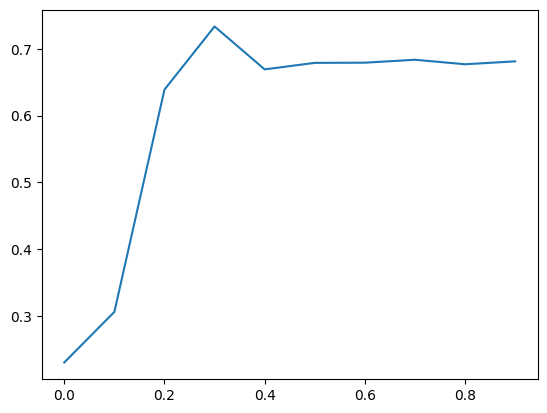

In [21]:
import matplotlib.pyplot as plt

plt.plot(x,y3)


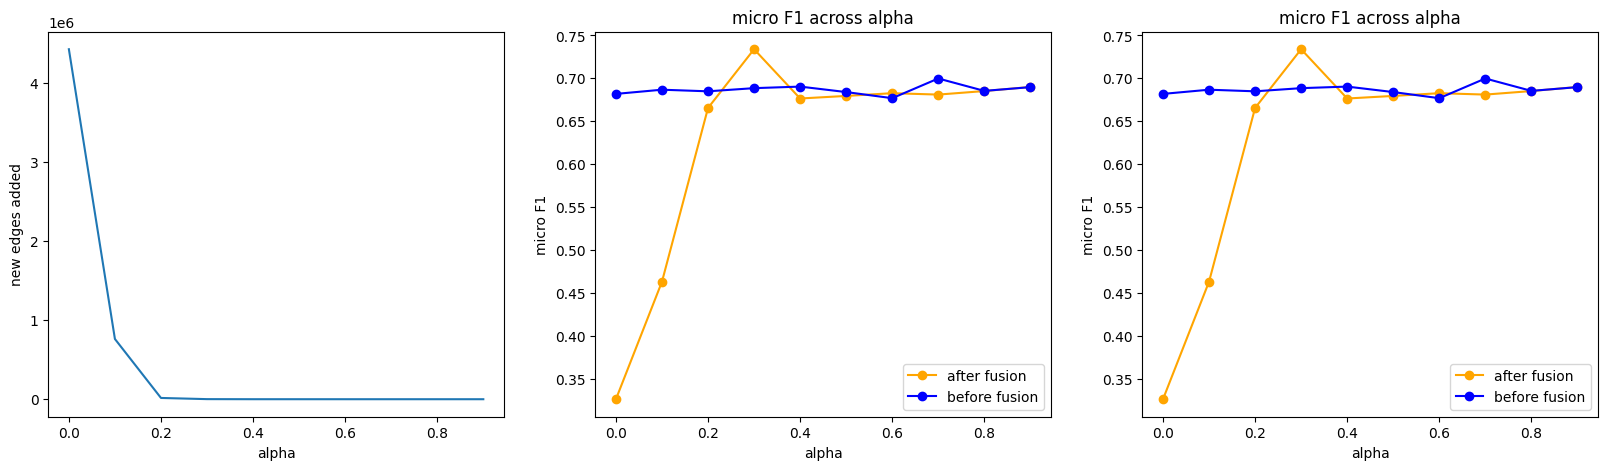

In [22]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(x,y1)
plt.xlabel('alpha')
plt.ylabel('new edges added')


plt.subplot(1,3,2)
plt.plot(x,y2,label="after fusion",marker="o",color="orange")
plt.plot(x,y4,label='before fusion',marker='o',color='blue')

plt.xlabel('alpha')
plt.ylabel('micro F1')
plt.title('micro F1 across alpha')
plt.legend()


plt.subplot(1,3,3)
plt.plot(x,y2,label="after fusion",marker="o",color="orange")
plt.plot(x,y4,label='before fusion',marker='o',color='blue')

plt.xlabel('alpha')
plt.ylabel('micro F1')
plt.title('micro F1 across alpha')
plt.legend()

plt.show()



# Method:2
- give weight 1 to all the existing edges
- find the new edges with similarity above some threshold
- scale the new edges similarity between 0 to 1
- include the new edges to the structural graph with edge weights acc to the scaled similarities
- the edges present in both exiting edges andnew edges will have weight more than 1

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Flickr, Coauthor, CoraFull, Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.loader import NeighborLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import networkx as nx
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

/home/bolt17/miniconda3/envs/StableVITON/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SEED=548
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import sklearn
sklearn.utils.check_random_state(SEED)
#-----------------------------------------
def edge_index_to_adj(edge_index, num_nodes):
    values = torch.ones(edge_index.shape[1])
    adj_matrix = torch.sparse_coo_tensor(edge_index, values, (num_nodes, num_nodes))
    return adj_matrix.to_dense()

dataset = Planetoid(root='data/Planetoid', name='Cora')
data = dataset[0]  # The dataset contains a single graph
print(data)
adj_matrix = edge_index_to_adj(data.edge_index, len(data.x))

features = torch.tensor(data.x)
# finding feature similarity across all the nodes via dot product
similarities = (features@features.T)

# making the diagnol elements to zero as the max similarity is obtained with a same
similarities = similarities * (torch.eye(len(similarities)) == 0).long()

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


/tmp/ipykernel_12769/1516843027.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


In [182]:
data.edge_weight = torch.ones((1, data.edge_index.shape[1]), dtype=torch.float32)

In [163]:
maxi=similarities.max()
print(f"maximum cross similarity:{maxi}")

# normalizing similarty to lie in range [0,1]
similarities=torch.div(similarities, maxi)

alpha = 0.3
print(f"alpha:{alpha}")

max_similarities = (similarities > alpha).long()

prev_edges = data.edge_index
prev_edge_weights = data.edge_weight

new_edges = torch.nonzero(max_similarities, as_tuple=False).T

new_edges_similarities=[]
for i in range(new_edges.shape[1]):
    new_edges_similarities.append(similarities[new_edges[0][i]][new_edges[1][i]].numpy().item())
max_sim=max(new_edges_similarities)
scaled_new_similarities = [i/max_sim for i in new_edges_similarities]

existing_edges = set(map(tuple, data.edge_index.T.tolist()))

common_edges = []
common_idxs = []
idxs = []
# check if there is a common edges between the ones we found and existing ones
filtered_new_edges = []
filtered_edges_sim = []
for idx,edge in enumerate(new_edges.T.tolist()):
    if (edge[0], edge[1]) not in existing_edges and (edge[1], edge[0]) not in existing_edges:  # Avoid duplicates
        filtered_new_edges.append([edge[0], edge[1]])
        filtered_edges_sim.append(scaled_new_similarities[idx])
    else:
        common_edges.append([edge[0],edge[1]])
        common_idxs.append(idx)

if filtered_new_edges:
    filtered_new_edges = torch.tensor(filtered_new_edges, dtype=torch.long).T  # Shape: [2, num_new_edges]
    # Convert filtered_edges_sim to tensor and reshape to match data.edge_weight's dimensions
    new_edges_simil = torch.tensor(filtered_edges_sim, dtype=torch.float32).reshape(1, -1)  # Shape: [1, num_new_edges]
    
    # Append new edges to data.edge_index
    data.edge_index = torch.cat([data.edge_index, filtered_new_edges], dim=1)
    data.edge_weight = torch.cat([data.edge_weight, new_edges_simil], dim=1)

print(f"Total new edges added: {filtered_new_edges.shape[1] if len(filtered_new_edges) > 0 else 0}")
data.edge_weight = torch.ones((1, data.edge_index.shape[1]), dtype=torch.float32)
new_edges = data.edge_index
new_edge_weights = data.edge_weight
print(f"previous_edges:{len(prev_edges[0])}")
print(f"new_edges:{len(new_edges[0])}")

maximum cross similarity:25.0
alpha:0.3
Total new edges added: 1168
previous_edges:10556
new_edges:11724


In [ ]:
maxi = similarities.max()
print(f"maximum cross similarity:{maxi}")

# normalizing similarity to lie in range [0,1]
similarities = torch.div(similarities, maxi)

alpha = 0.3
print(f"alpha:{alpha}")

max_similarities = (similarities > alpha).long()

prev_edges = data.edge_index
prev_edge_weights = data.edge_weight.clone()  # Create a copy to preserve original weights

new_edges = torch.nonzero(max_similarities, as_tuple=False).T

new_edges_similarities = []
for i in range(new_edges.shape[1]):
    new_edges_similarities.append(similarities[new_edges[0][i]][new_edges[1][i]].numpy().item())
max_sim = max(new_edges_similarities)
scaled_new_similarities = [i/max_sim for i in new_edges_similarities]

existing_edges = set(map(tuple, data.edge_index.T.tolist()))

common_edges = []
common_idxs = []
filtered_new_edges = []
filtered_edges_sim = []

# Store mapping of common edges to their similarity values
common_edge_to_sim = {}

for idx, edge in enumerate(new_edges.T.tolist()):
    edge_tuple = (edge[0], edge[1])
    if (edge[0], edge[1]) not in existing_edges and (edge[1], edge[0]) not in existing_edges:
        filtered_new_edges.append([edge[0], edge[1]])
        filtered_edges_sim.append(scaled_new_similarities[idx])
    else:
        common_edges.append([edge[0], edge[1]])
        common_idxs.append(idx)
        common_edge_to_sim[edge_tuple] = scaled_new_similarities[idx]
f=False
# Update weights of common edges in prev_edge_weights
if common_edges:
    # Convert prev_edges to list of tuples for easier lookup
    prev_edges_list = prev_edges.T.tolist()
    for i, edge in enumerate(prev_edges_list):
        edge_tuple = tuple(edge)
        if edge_tuple in common_edge_to_sim:
            # Update the weight (you can adjust how you want to increase it)
            prev_edge_weights[0, i] = prev_edge_weights[0, i] + torch.tensor(common_edge_to_sim[edge_tuple], dtype=torch.float32)

if filtered_new_edges:
    filtered_new_edges = torch.tensor(filtered_new_edges, dtype=torch.long).T
    new_edges_simil = torch.tensor(filtered_edges_sim, dtype=torch.float32).reshape(1, -1)
    
    # Append new edges to data.edge_index
    data.edge_index = torch.cat([data.edge_index, filtered_new_edges], dim=1)
    data.edge_weight = torch.cat([prev_edge_weights, new_edges_simil], dim=1)

print(f"Total new edges added: {filtered_new_edges.shape[1] if len(filtered_new_edges) > 0 else 0}")
new_edges = data.edge_index
new_edge_weights = data.edge_weight
print(f"previous_edges:{len(prev_edges[0])}")
print(f"new_edges:{len(new_edges[0])}")

maximum cross similarity:1.0
alpha:0.3
True
Total new edges added: 0
previous_edges:11724
new_edges:11724


In [184]:
prev_edges_and_weights = torch.cat([prev_edges, prev_edge_weights], dim=0)
print(prev_edges_and_weights.shape)
new_edges_and_weights = torch.cat([new_edges, new_edge_weights], dim=0)
print(new_edges_and_weights.shape)

torch.Size([3, 10556])
torch.Size([3, 11724])


In [4]:
# save_edges = lambda args: pd.DataFrame(args[0].T).to_csv(args[1],index=None, header=None, sep=' ', mode='a')
save_edges = lambda args: pd.DataFrame(args[0].T, columns=['col1', 'col2', 'col3']).astype(
    {'col1': int, 'col2': int, 'col3': int}
).to_csv(args[1], index=None, header=None, sep=' ', mode='a', float_format='%.1f')
def get_embeddings(
    edges, 
    edges_name="edgelist.txt", 
    k=128,  # Embedding dimension
    a=0.01,  # damping parameter
    partition=1,
    output=False
):
    '''
    "partition": the partition algorithm to use, default is 1.
    0: random bisection
    1: Louvain partition
    2: Louvain first-level partition
    3: Label Propagation partition
    '''
    open(edges_name,'w').close()
    save_edges((edges, edges_name))

    if not os.path.exists('./hierarchy.txt'):
        os.mknod('./hierarchy.txt')
    else:
        open('hierarchy.txt','w').close()
    if not os.path.exists('./vectors.txt'):
        os.mknod('./vectors.txt')
    else:
        open('vectors.txt','w').close()
    
    # do hierarchical clustering using Louvain algorithm
    endstr = '> /dev/null 2>&1'
    if(output):
        endstr = ''
    os.system(f'./LouvainNE/recpart ./{edges_name} ./hierarchy.txt {partition} {endstr}')
    
    # obtain node embedding of each node at every hierarchy
    os.system(f'./LouvainNE/hi2vec {k} {a} ./hierarchy.txt ./vectors.txt {endstr}')
    
    # Path to your output node embeddings text file
    file_path = 'vectors.txt'

    data_ = np.loadtxt(file_path)
    data_tensor = torch.from_numpy(data_)
    # The first column contains node IDs
    node_ids = data_tensor[:, 0].to(torch.int)
    # The remaining columns contain embeddings
    embeddings = data_tensor[:, 1:]
    return node_ids, embeddings

In [5]:
def evaluate_node_classification(aa_node_ids, aa_embeddings, data):
    """
    Evaluates multi-class node classification using Logistic Regression.

    Args:
        aa_node_ids: List of node IDs.
        aa_embeddings: Corresponding node embeddings.
        data: PyTorch Geometric data object containing labels and masks.

    Returns:
        Micro-F1 and Macro-F1 scores.
    """

    # Map node IDs to indices in embeddings
    node_to_idx = {node_id.item(): idx for idx, node_id in enumerate(aa_node_ids)}

    # Reorder embeddings to match the label ordering
    ordered_embeddings = np.zeros((len(data.y), aa_embeddings.shape[1]))
    for i in range(len(data.y)):
        ordered_embeddings[i] = aa_embeddings[node_to_idx[i]]

    # Convert masks to NumPy arrays
    train_mask = data.train_mask.numpy()
    test_mask = data.test_mask.numpy()

    # Prepare train and test data
    X_train, X_test = ordered_embeddings[train_mask], ordered_embeddings[test_mask]
    y_train, y_test = data.y[train_mask].numpy(), data.y[test_mask].numpy()

    # Train Logistic Regression classifier
    clf = LogisticRegression(max_iter=1000, solver='lbfgs')
    clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(X_test)

    # Compute Micro-F1 and Macro-F1 scores
    micro_f1 = f1_score(y_test, y_pred, average='micro')
    macro_f1 = f1_score(y_test, y_pred, average='macro')

    return {
        'micro_f1': micro_f1,
        'macro_f1': macro_f1
    }


In [187]:
print('Only Initial Edges:')


a = []
b = []
for i in tqdm(range(16)):
    aa_node_ids, aa_embeddings = get_embeddings(prev_edges_and_weights, "prev_edgelist.txt", k=256, partition=1)
    # print(aa_node_ids.shape)
    # print(aa_embeddings.shape)
    result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
    a.append(result['micro_f1'])
    b.append(result['macro_f1'])

print(f"Micro-F1: {np.mean(a):.4f} ± {np.std(a):.4f}")
print(f"Macro-F1: {np.mean(b):.4f} ± {np.std(b):.4f}")

print('Combined Edges:')
a = []
b = []
for i in tqdm(range(16)):
    aa_node_ids, aa_embeddings = get_embeddings(new_edges_and_weights, "new_edgelist.txt", k=256, partition=1)
    result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
    a.append(result['micro_f1'])
    b.append(result['macro_f1'])

print(f"Micro-F1: {np.mean(a):.4f} ± {np.std(a):.4f}")
print(f"Macro-F1: {np.mean(b):.4f} ± {np.std(b):.4f}")

Only Initial Edges:


100%|██████████| 16/16 [00:03<00:00,  4.97it/s]


Micro-F1: 0.6796 ± 0.0088
Macro-F1: 0.6754 ± 0.0082
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  5.14it/s]

Micro-F1: 0.6967 ± 0.0097
Macro-F1: 0.6923 ± 0.0081


In [ ]:
def evalator(alpha):
    
    dataset = Planetoid(root='data/Planetoid', name='Cora')
    data = dataset[0]  # The dataset contains a single graph
    print(data)
    data.edge_weight = torch.ones((1, data.edge_index.shape[1]), dtype=torch.float32)
    adj_matrix = edge_index_to_adj(data.edge_index, len(data.x))

    features = torch.tensor(data.x)
    # finding feature similarity across all the nodes via dot product
    similarities = (features@features.T)

# making the diagnol elements to zero as the max similarity is obtained with a same
    similarities = similarities * (torch.eye(len(similarities)) == 0).long()
    
    maxi = similarities.max()
    print(f"maximum cross similarity:{maxi}")

    # normalizing similarity to lie in range [0,1]
    similarities = torch.div(similarities, maxi)

    # alpha = 0.3
    print(f"alpha:{alpha}")

    max_similarities = (similarities > alpha).long()

    prev_edges = data.edge_index
    prev_edge_weights = data.edge_weight.clone()  # Create a copy to preserve original weights

    new_edges = torch.nonzero(max_similarities, as_tuple=False).T

    new_edges_similarities = []
    for i in range(new_edges.shape[1]):
        new_edges_similarities.append(similarities[new_edges[0][i]][new_edges[1][i]].numpy().item())
    max_sim = max(new_edges_similarities)
    scaled_new_similarities = [i/max_sim for i in new_edges_similarities]

    existing_edges = set(map(tuple, data.edge_index.T.tolist()))

    common_edges = []
    common_idxs = []
    filtered_new_edges = []
    filtered_edges_sim = []

    # Store mapping of common edges to their similarity values
    common_edge_to_sim = {}

    for idx, edge in enumerate(new_edges.T.tolist()):
        edge_tuple = (edge[0], edge[1])
        if (edge[0], edge[1]) not in existing_edges and (edge[1], edge[0]) not in existing_edges:
            filtered_new_edges.append([edge[0], edge[1]])
            filtered_edges_sim.append(scaled_new_similarities[idx])
        else:
            common_edges.append([edge[0], edge[1]])
            common_idxs.append(idx)
            common_edge_to_sim[edge_tuple] = scaled_new_similarities[idx]
    f=False
    # Update weights of common edges in prev_edge_weights
    if common_edges:
        # Convert prev_edges to list of tuples for easier lookup
        prev_edges_list = prev_edges.T.tolist()
        for i, edge in enumerate(prev_edges_list):
            edge_tuple = tuple(edge)
            if edge_tuple in common_edge_to_sim:
                # Update the weight (you can adjust how you want to increase it)
                prev_edge_weights[0, i] = prev_edge_weights[0, i] + torch.tensor(common_edge_to_sim[edge_tuple], dtype=torch.float32)

    if filtered_new_edges:
        filtered_new_edges = torch.tensor(filtered_new_edges, dtype=torch.long).T
        new_edges_simil = torch.tensor(filtered_edges_sim, dtype=torch.float32).reshape(1, -1)
        
        # Append new edges to data.edge_index
        data.edge_index = torch.cat([data.edge_index, filtered_new_edges], dim=1)
        data.edge_weight = torch.cat([prev_edge_weights, new_edges_simil], dim=1)

    print(f"Total new edges added: {filtered_new_edges.shape[1] if len(filtered_new_edges) > 0 else 0}")
    new_edges = data.edge_index
    new_edge_weights = data.edge_weight

    prev_edges_and_weights = torch.cat([prev_edges, prev_edge_weights], dim=0)
    new_edges_and_weights = torch.cat([new_edges, new_edge_weights], dim=0)

    print('Only Initial Edges:')
    a1 = []
    b1 = []
    for i in tqdm(range(16)):
        aa_node_ids, aa_embeddings = get_embeddings(prev_edges_and_weights, "prev_edgelist.txt", k=256, partition=1)
        result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
        a1.append(result['micro_f1'])
        b1.append(result['macro_f1'])

    print(f"Micro-F1: {np.mean(a1):.4f} ± {np.std(a1):.4f}")
    print(f"Macro-F1: {np.mean(b1):.4f} ± {np.std(b1):.4f}")

    print('Combined Edges:')
    a2 = []
    b2 = []
    for i in tqdm(range(16)):
        aa_node_ids, aa_embeddings = get_embeddings(new_edges_and_weights, "new_edgelist.txt", k=256, partition=1)
        result = evaluate_node_classification(aa_node_ids, aa_embeddings, data)
        a2.append(result['micro_f1'])
        b2.append(result['macro_f1'])

    print(f"Micro-F1: {np.mean(a2):.4f} ± {np.std(a2):.4f}")
    print(f"Macro-F1: {np.mean(b2):.4f} ± {np.std(b2):.4f}")
    
    return alpha,filtered_new_edges.shape[1],np.mean(a2),np.mean(b2),np.mean(a1),np.mean(b1)

In [7]:
x=[] #alpha
y1=[] # edge count added
y2=[] #micro
y3=[] #macro
y4=[]# micro
y5=[] # marcro
for alpha in range(0,10):
    print("---------------------------------------------")
    alpha=alpha/10
    print("alpha:",alpha)
    xx,y1a,y2b,y3c,y4d,y5e=evalator(alpha)
    x.append(xx)
    y1.append(y1a)
    y2.append(y2b)
    y3.append(y3c)
    y4.append(y4d)
    y5.append(y5e)

---------------------------------------------
alpha: 0.0
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.0


/tmp/ipykernel_12769/3947828958.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Total new edges added: 4428556


100%|██████████| 16/16 [00:03<00:00,  5.10it/s]


Micro-F1: 0.6881 ± 0.0059
Macro-F1: 0.6836 ± 0.0036
Combined Edges:


100%|██████████| 16/16 [00:48<00:00,  3.04s/it]
/tmp/ipykernel_12769/3947828958.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6704 ± 0.0110
Macro-F1: 0.6717 ± 0.0087
---------------------------------------------
alpha: 0.1
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.1
Total new edges added: 762060


100%|██████████| 16/16 [00:03<00:00,  5.33it/s]


Micro-F1: 0.6951 ± 0.0072
Macro-F1: 0.6907 ± 0.0058
Combined Edges:


100%|██████████| 16/16 [00:11<00:00,  1.39it/s]
/tmp/ipykernel_12769/3947828958.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6760 ± 0.0106
Macro-F1: 0.6750 ± 0.0072
---------------------------------------------
alpha: 0.2
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.2
Total new edges added: 16050


100%|██████████| 16/16 [00:02<00:00,  5.53it/s]


Micro-F1: 0.6838 ± 0.0108
Macro-F1: 0.6774 ± 0.0096
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  5.32it/s]
/tmp/ipykernel_12769/3947828958.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6788 ± 0.0024
Macro-F1: 0.6776 ± 0.0024
---------------------------------------------
alpha: 0.3
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.3
Total new edges added: 1168


100%|██████████| 16/16 [00:02<00:00,  5.34it/s]


Micro-F1: 0.6748 ± 0.0064
Macro-F1: 0.6690 ± 0.0068
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  5.30it/s]
/tmp/ipykernel_12769/3947828958.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.7005 ± 0.0065
Macro-F1: 0.6953 ± 0.0074
---------------------------------------------
alpha: 0.4
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.4
Total new edges added: 180


100%|██████████| 16/16 [00:03<00:00,  5.25it/s]


Micro-F1: 0.6901 ± 0.0029
Macro-F1: 0.6859 ± 0.0022
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  5.19it/s]
/tmp/ipykernel_12769/3947828958.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6915 ± 0.0019
Macro-F1: 0.6866 ± 0.0033
---------------------------------------------
alpha: 0.5
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.5
Total new edges added: 126


100%|██████████| 16/16 [00:03<00:00,  5.30it/s]


Micro-F1: 0.6821 ± 0.0087
Macro-F1: 0.6767 ± 0.0059
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  5.22it/s]
/tmp/ipykernel_12769/3947828958.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6907 ± 0.0035
Macro-F1: 0.6839 ± 0.0038
---------------------------------------------
alpha: 0.6
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.6
Total new edges added: 92


100%|██████████| 16/16 [00:03<00:00,  4.56it/s]


Micro-F1: 0.6881 ± 0.0103
Macro-F1: 0.6840 ± 0.0077
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.97it/s]
/tmp/ipykernel_12769/3947828958.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.7035 ± 0.0111
Macro-F1: 0.6942 ± 0.0069
---------------------------------------------
alpha: 0.7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.7
Total new edges added: 74


100%|██████████| 16/16 [00:03<00:00,  4.93it/s]


Micro-F1: 0.6850 ± 0.0089
Macro-F1: 0.6818 ± 0.0086
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.50it/s]
/tmp/ipykernel_12769/3947828958.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.6955 ± 0.0031
Macro-F1: 0.6899 ± 0.0018
---------------------------------------------
alpha: 0.8
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.8
Total new edges added: 34


100%|██████████| 16/16 [00:03<00:00,  4.86it/s]


Micro-F1: 0.6955 ± 0.0042
Macro-F1: 0.6877 ± 0.0052
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.90it/s]
/tmp/ipykernel_12769/3947828958.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(data.x)


Micro-F1: 0.7055 ± 0.0136
Macro-F1: 0.6970 ± 0.0095
---------------------------------------------
alpha: 0.9
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
maximum cross similarity:25.0
alpha:0.9
Total new edges added: 22


100%|██████████| 16/16 [00:03<00:00,  4.97it/s]


Micro-F1: 0.6816 ± 0.0078
Macro-F1: 0.6776 ± 0.0075
Combined Edges:


100%|██████████| 16/16 [00:03<00:00,  4.84it/s]

Micro-F1: 0.6846 ± 0.0058
Macro-F1: 0.6783 ± 0.0081


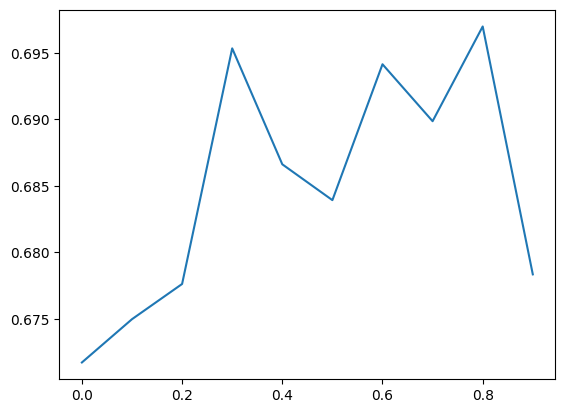

In [8]:
import matplotlib.pyplot as plt

plt.plot(x,y3)


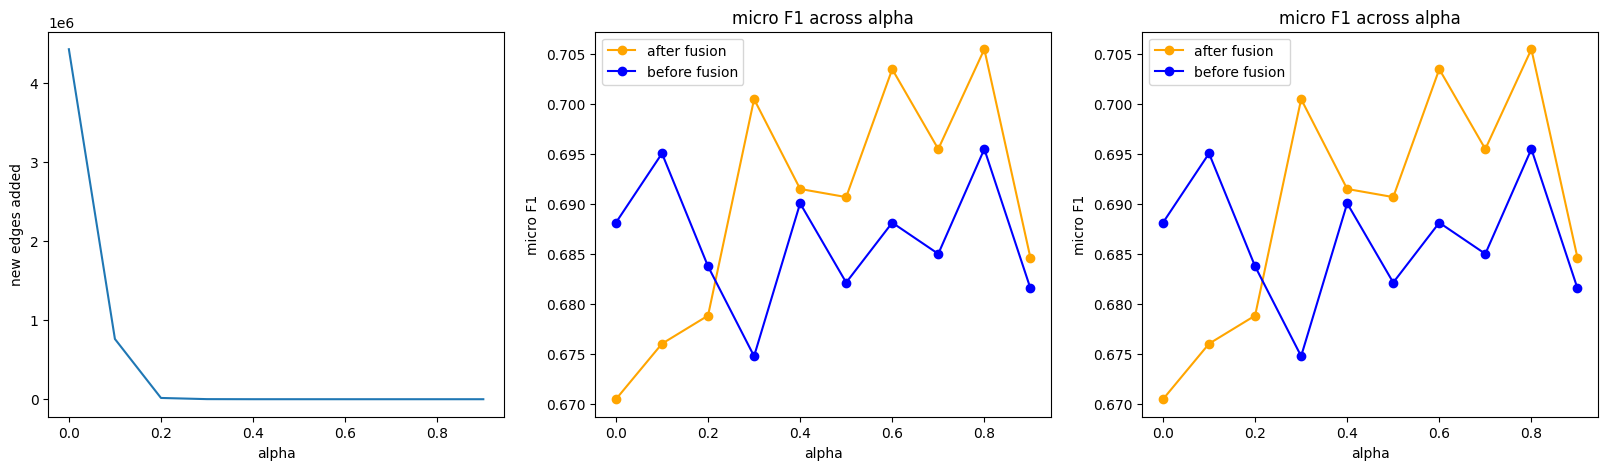

In [9]:
plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.plot(x,y1)
plt.xlabel('alpha')
plt.ylabel('new edges added')


plt.subplot(1,3,2)
plt.plot(x,y2,label="after fusion",marker="o",color="orange")
plt.plot(x,y4,label='before fusion',marker='o',color='blue')

plt.xlabel('alpha')
plt.ylabel('micro F1')
plt.title('micro F1 across alpha')
plt.legend()


plt.subplot(1,3,3)
plt.plot(x,y2,label="after fusion",marker="o",color="orange")
plt.plot(x,y4,label='before fusion',marker='o',color='blue')

plt.xlabel('alpha')
plt.ylabel('micro F1')
plt.title('micro F1 across alpha')
plt.legend()

plt.show()

